# Algorithmic Fairness in Criminal Justice: The COMPAS Case

The use of algorithmic risk assessment tools in criminal justice has become a focal point in debates about fairness, accountability, and the ethics of artificial intelligence. This notebook examines the **COMPAS (Correctional Offender Management Profiling for Alternative Sanctions)** recidivism risk assessment algorithm, which has been widely deployed across the United States to inform bail, sentencing, and parole decisions.

## Dataset Overview

The dataset consists of **7,214 criminal defendants** from Broward County, Florida, scored by the COMPAS algorithm between 2013 and 2014. For each defendant, we observe:

- **Demographics**: `sex`, `age`, `race`
- **COMPAS risk assessment**:
    - `decile_score`: 1-10, where higher scores indicate higher predicted recidivism risk
    - `score_text`: Low, Medium, High
- **Recidivism outcomes**: 
    - `two_year_recid`: whether the defendant was re-arrested within two years
    - `is_recid`: whether they committed any offense
    - `is_violent_recid`: whether they committed a violent offense

This analysis focuses on comparing COMPAS score distributions and false positive rates across racial groups, with particular attention to disparities between Black and White defendants.

## Notebook Outline

This analysis proceeds in three parts:

1. **Bootstrap Estimates of Score Distributions**: We use the bootstrap to quantify uncertainty in race-conditioned summary statistics of COMPAS decile scores, specifically the mean score and interquartile range (IQR). These distributional differences provide context for understanding how score assignments vary across racial groups and mechanically generate disparities in classification rates.

2. **Permutation Test for False Positive Rate Disparity**: We formally test whether Black and White defendants experience different false positive rates using a permutation test. By treating race labels as exchangeable under the null hypothesis of no disparity, we assess whether observed differences in FPR are statistically significant or consistent with random variation.

3. **Implications for Algorithmic Fairness**: We interpret the results in light of competing fairness criteria and discuss the broader implications for deploying risk assessment tools in high-stakes settings. The analysis highlights fundamental tensions between different notions of fairness and the challenges of aligning algorithmic decisions with principles of justice and equity.


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load dataset
compas_scores = pd.read_csv('./data/compas-scores-two-years.csv')

# Keep only a number of interesting columns
to_keep = ['sex', 'age', 'race', 'decile_score', 'score_text', 'is_recid', 'is_violent_recid', 'two_year_recid']
compas_scores = compas_scores[to_keep]

# Rename races for simplicity
compas_scores['race'] = compas_scores['race'].replace({'African-American': 'Black', 'Caucasian': 'White'})

# Cast scores to float
compas_scores['decile_score'] = compas_scores['decile_score'].astype(float)

compas_scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214 entries, 0 to 7213
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   sex               7214 non-null   object 
 1   age               7214 non-null   int64  
 2   race              7214 non-null   object 
 3   decile_score      7214 non-null   float64
 4   score_text        7214 non-null   object 
 5   is_recid          7214 non-null   int64  
 6   is_violent_recid  7214 non-null   int64  
 7   two_year_recid    7214 non-null   int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 451.0+ KB


## 1. Bootstrap Estimates of Score Distributions
Before formally testing for disparities in false positive rates, we examine whether COMPAS assigns systematically different risk score distributions to defendants across race groups. Differences in the location or dispersion of risk scores can mechanically generate disparities in false positive rates when a fixed threshold is applied, even prior to conditioning on observed recidivism outcomes.

To quantify these distributional differences and their associated uncertainty, we use the bootstrap to estimate confidence intervals for two race-conditioned score statistics: the mean decile score and the interquartile range (IQR) of decile scores.

Let $S=\texttt{decile_score}\in\{1,\ldots,10\}$ denote the COMPAS risk score and $G=\texttt{race}\in\{\textrm{White}, \textrm{Black},\ldots\}$ denote the race group.

### Mean decile score by race
We first consider the expected COMPAS score within each race group:
$$
\mu_g = \mathbb{E}[S \mid G=g]
$$
Differences in mean scores indicate whether one group is systematically assigned higher risk assessments on average. A higher mean score implies a greater likelihood that defendants will exceed a fixed high-risk threshold, thereby increasing the potential for false positive classifications.

We estimate uncertainty in $\mu_g$ using the nonparametric bootstrap by resampling defendants with replacement and recomputing the mean decile score within each race group. Because the mean is a smooth functional of the score distribution, its sampling distribution is reasonably well approximated by the Central Limit Theorem; the bootstrap serves to quantify finite-sample uncertainty.

In [3]:
# Perform bootstrap estimates of mean decile score
compas_scores_summary = compas_scores.groupby('race')['decile_score'].agg(['count', 'mean']).reset_index()
compas_scores_summary.columns = ['race', 'count', 'mean_actual']
compas_scores_summary['mean'] = pd.NA
compas_scores_summary['se_mean'] = pd.NA
compas_scores_summary['lower_mean'] = pd.NA
compas_scores_summary['upper_mean'] = pd.NA

for race in compas_scores_summary['race'].unique():
    this_score = compas_scores[compas_scores['race'] == race]

    samples_mean = []
    for _ in range(10_000):
        this_sample = this_score.sample(frac=1, replace=True)
        samples_mean.append(np.mean(this_sample['decile_score']))

    compas_scores_summary.loc[compas_scores_summary['race'] == race, 'mean'] = np.mean(samples_mean)
    compas_scores_summary.loc[compas_scores_summary['race'] == race, 'se_mean']  = np.std(samples_mean)
    compas_scores_summary.loc[compas_scores_summary['race'] == race, 'lower_mean'] = np.quantile(samples_mean, 0.025)
    compas_scores_summary.loc[compas_scores_summary['race'] == race, 'upper_mean'] = np.quantile(samples_mean, 0.975)

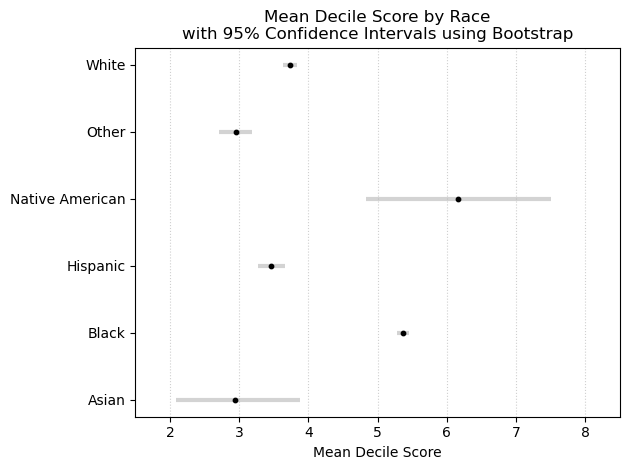

In [4]:
# Plot mean score with confidence intervals using Bootstrap

# CI lines
plt.hlines(
    y=compas_scores_summary['race'],
    xmin=compas_scores_summary['lower_mean'],
    xmax=compas_scores_summary['upper_mean'],
    color='lightgray',
    lw=3,
    zorder=1
)

# Point estimates
plt.scatter(
    compas_scores_summary['mean'],
    compas_scores_summary['race'],
    s=10,
    color='black',
    zorder=2
)

plt.xlabel('Mean Decile Score')
plt.ylabel('')
plt.title('Mean Decile Score by Race\nwith 95% Confidence Intervals using Bootstrap')
plt.grid(axis='x', linestyle=':', alpha=0.6, zorder=0)
plt.xlim([1.5, 8.5])
plt.tight_layout()
plt.savefig('./results/forest_mean_score.png', dpi=300)
plt.show()

#### Interpretation
The bootstrap results show a clear difference in mean COMPAS decile scores across race groups. Black defendants have a substantially higher average score than White defendants, with narrow and non-overlapping confidence intervals, reflecting a precise and sizeable difference. This upward shift in the score distribution implies that, for any fixed threshold, Black defendants are more likely to be classified as high risk.

### IQR of decile score by race
To capture differences in score dispersion, we also consider the interquartile range of COMPAS scores:
$$
\mathrm{IQR}_g = Q_{0.75}(S \mid G=g) - Q_{0.25}(S \mid G=g)
$$

The IQR measures the spread of the middle 50% of the score distribution within each race group. Greater dispersion implies more mass in the upper tail of the score distribution, which can increase the frequency with which defendants exceed a high-risk threshold even if group means are similar.

Unlike the mean, the IQR is a non-smooth functional of the distribution and does not admit a simple normal approximation. We therefore rely on the bootstrap to estimate uncertainty in $\mathrm{IQR}_g$ by resampling defendants and recomputing the IQR within each race group.

In [5]:
# Define function to calculate IQR
def iqr_func(series):
    q75, q25 = np.quantile(series, [0.75, 0.25])
    return q75 - q25

In [6]:
# Perform bootstrap estimates of IQR decile score
compas_scores_summary['iqr_actual'] = pd.NA
compas_scores_summary['iqr'] = pd.NA
compas_scores_summary['se_iqr'] = pd.NA
compas_scores_summary['lower_iqr'] = pd.NA
compas_scores_summary['upper_iqr'] = pd.NA

for race in compas_scores_summary['race'].unique():
    this_score = compas_scores[compas_scores['race'] == race]

    samples_iqr = []
    for _ in range(10_000):
        this_sample = this_score.sample(frac=1, replace=True).copy()
        this_sample['decile_score'] = this_sample['decile_score'] + np.random.uniform(-0.5, 0.5, size=len(this_sample)) # add Gaussian noise to overcome issue with discrete scores
        samples_iqr.append(iqr_func(this_sample['decile_score']))

    compas_scores_summary.loc[compas_scores_summary['race'] == race, 'iqr'] = np.mean(samples_iqr)
    compas_scores_summary.loc[compas_scores_summary['race'] == race, 'se_iqr']  = np.std(samples_iqr)
    compas_scores_summary.loc[compas_scores_summary['race'] == race, 'lower_iqr'] = np.quantile(samples_iqr, 0.025)
    compas_scores_summary.loc[compas_scores_summary['race'] == race, 'upper_iqr'] = np.quantile(samples_iqr, 0.975)

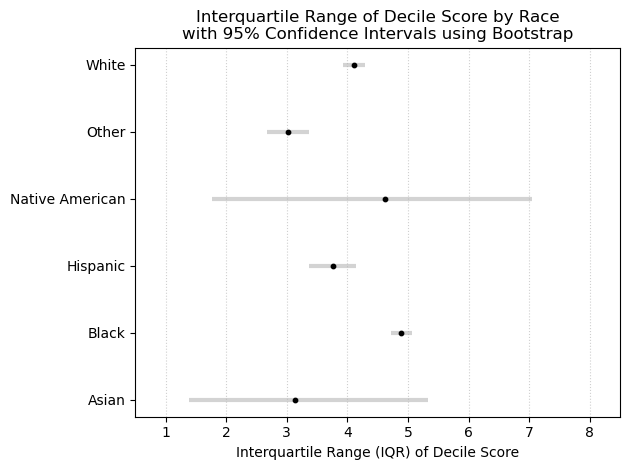

In [7]:
# Plot IQR with confidence intervals using Bootstrap

# CI lines
plt.hlines(
    y=compas_scores_summary['race'],
    xmin=compas_scores_summary['lower_iqr'],
    xmax=compas_scores_summary['upper_iqr'],
    color='lightgray',
    lw=3,
    zorder=1
)

# Point estimates
plt.scatter(
    compas_scores_summary['iqr'],
    compas_scores_summary['race'],
    s=10,
    color='black',
    zorder=2
)

plt.xlabel('Interquartile Range (IQR) of Decile Score')
plt.ylabel('')
plt.title('Interquartile Range of Decile Score by Race\nwith 95% Confidence Intervals using Bootstrap')
plt.grid(axis='x', linestyle=':', alpha=0.6, zorder=0)
plt.tight_layout()
plt.xlim([0.5, 8.5])
plt.savefig('./results/forest_iqr_score.png', dpi=300)
plt.show()

#### Interpretation
The bootstrap estimates indicate that Black defendants have a larger interquartile range of COMPAS decile scores than White defendants, suggesting greater dispersion in assigned risk scores. The confidence intervals for Black and White defendants show limited overlap, while intervals for smaller groups are wide due to sample size. Greater score dispersion implies more mass in the upper tail of the score distribution, increasing the likelihood of exceeding a fixed high-risk threshold.

## 2. Permutation Test for False Positive Rate Disparity
To assess whether COMPAS satisfies equality across race, we test whether false positive rates differ between Black and White defendants. We resitrict attention to non-recidivists and use a permutation test that treats race labels as exchangeable under the null of no racial disparity in false positives.

Formally, we define the false positive rate (FPR) for a race group $g$ as:
$$
\mathrm{FPR}_g = P(\hat{Y}=1 \mid Y=0, G=g)
$$
where:
- $G = \texttt{race} \in \{\text{Black}, \text{White}\}$ defdines the race group
- $Y = \texttt{two_year_recid} \in \{0, 1\}$ defines the true outcome
- $\hat{Y}=\mathbf{1}\{\texttt{decile_score}\geq t\}$ defines the prediction given a threshold score $t$

The disparity in FPR is then given by:
$$
\Delta_\mathrm{FPR} = \mathrm{FPR}_\mathrm{Black} - \mathrm{FPR}_\mathrm{White}
$$
with interpretation:
- $\Delta_\mathrm{FPR}>0$: Black defendants are more likely to be falsely labled high risk
- $\Delta_\mathrm{FPR}<0$: White defendants are more likely to be falsely labled high risk

In that context, we formulate the following two-sided hypothesis test for a threshold score $t$:
$$
\begin{aligned}
H_0: \Delta_\mathrm{FPR}&=0\\
H_A: \Delta_\mathrm{FPR}&\neq0
\end{aligned}
$$

This tests the claim that false positve rate differs between Black and White defendants.

In [9]:
# Create a boolean mask to represent defendants with a high risk of recidivism
threshold_score = 5
compas_scores['high_risk'] = compas_scores['decile_score'] >= threshold_score

# Evaluate the false positive rate by race group
non_recid = compas_scores[compas_scores['two_year_recid'] == 0]
fpr_by_race = non_recid.groupby('race')['high_risk'].mean()

obs_diff = fpr_by_race['Black'] - fpr_by_race['White']
print(f'Difference in FPR by race (Black - White): {obs_diff:.3f}')

Difference in FPR by race (Black - White): 0.214


In [10]:
diffs = []
non_recid_replciate = non_recid.copy().reset_index()

for _ in range(10_000):
    non_recid_replciate['race'] = non_recid_replciate['race'].sample(frac=1, replace=False).reset_index(drop=True)
    fpr_by_race = non_recid_replciate.groupby('race')['high_risk'].mean()
    diffs.append(fpr_by_race['Black'] - fpr_by_race['White'])

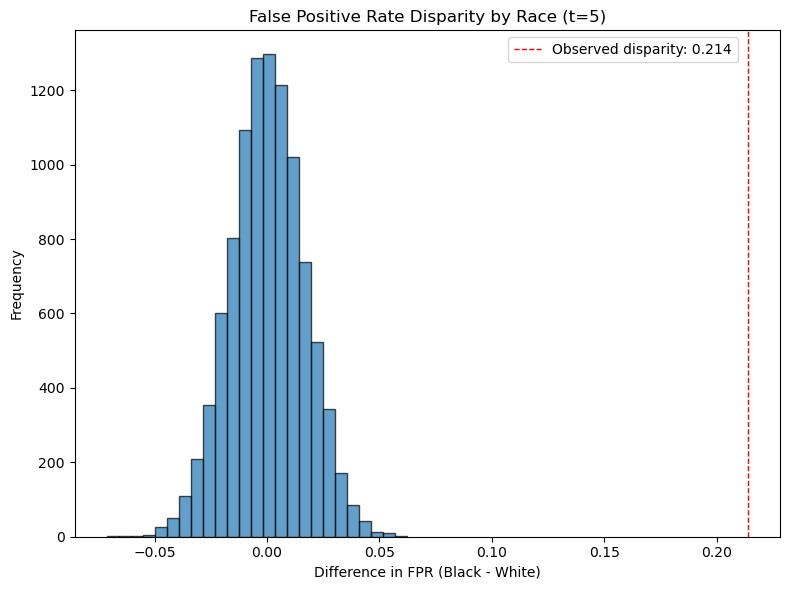

In [11]:
# Plot the distribution from the permutation test
plt.figure(figsize=(8, 6))
plt.hist(diffs, bins=25, edgecolor='k', alpha=0.7)
plt.axvline(obs_diff, color='red', linestyle='dashed', linewidth=1, label=f"Observed disparity: {obs_diff:.3f}")
plt.title('False Positive Rate Disparity by Race (t=5)')
plt.xlabel('Difference in FPR (Black - White)')
plt.ylabel('Frequency')
plt.legend(loc='upper right', bbox_to_anchor=(0.95, 1.00))
plt.tight_layout()
plt.savefig('./results/hist_fpr_disparity.png', dpi=300)
plt.show()

In [12]:
# Calculate the two-sided p-value
p_value = np.sum(np.abs(np.array(diffs)) >= np.abs(obs_diff)) / len(diffs)
print(f"p-value: {p_value:.3f}")

p-value: 0.000


#### Interpretation

We reject the null hypothesis ($H_0: \Delta_\mathrm{FPR}=0$) with $p\approx0$, which is well below any conventional significance level (e.g., $\alpha = 0.05$). 

This result provides strong statistical evidence that false positive rates differ significantly between Black and White defendants. Specifically, the observed disparity of 0.214 indicates that among non-recidivists, Black defendants are approximately 21.4 percentage points more likely to be incorrectly classified as high risk compared to White defendants when using a threshold score of 5.

The permutation test shows that this observed disparity is extremely unlikely to occur by chance under the assumption of no racial disparity in false positives, suggesting systematic differences in how COMPAS scores are distributed across racial groups. This finding supports concerns about racial disparities in the COMPAS risk assessment tool.

## 3. Implications for Algorithmic Fairness
This analysis demonstrates that COMPAS risk assessments exhibit statistically significant racial disparities in false positive rates. Through bootstrap estimation, we documented that Black defendants receive systematically higher risk scores with greater dispersion than White defendants. The permutation test provided decisive evidence ($p \approx 0$) that these distributional differences translate into unequal error rates: Black non-recidivists face substantially higher rates of misclassification as high-risk compared to White non-recidivists.

The statistical significance of this finding indicates that observed disparities cannot be attributed to random variation or sampling error. Instead, they reflect systematic patterns in how risk scores are assigned across racial groups. This raises profound questions about the deployment of algorithmic decision-making tools in criminal justice, where misclassification carries severe consequences for defendants' liberty, employment prospects, and life trajectories. The COMPAS case highlights that technical sophistication alone cannot guarantee fairness; meaningful accountability requires ongoing auditing, transparency about tradeoffs between competing fairness criteria, and democratic deliberation about whose interests algorithmic systems should serve.
